In [1]:
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Urban Drone Demo
## Model Overview
The drone model is defined in `drone_mdl_urban.py`, along with some visualization functions.

In [2]:
from drone_mdl_urban import Drone

In [3]:
mdl = Drone()

This is the model structure:

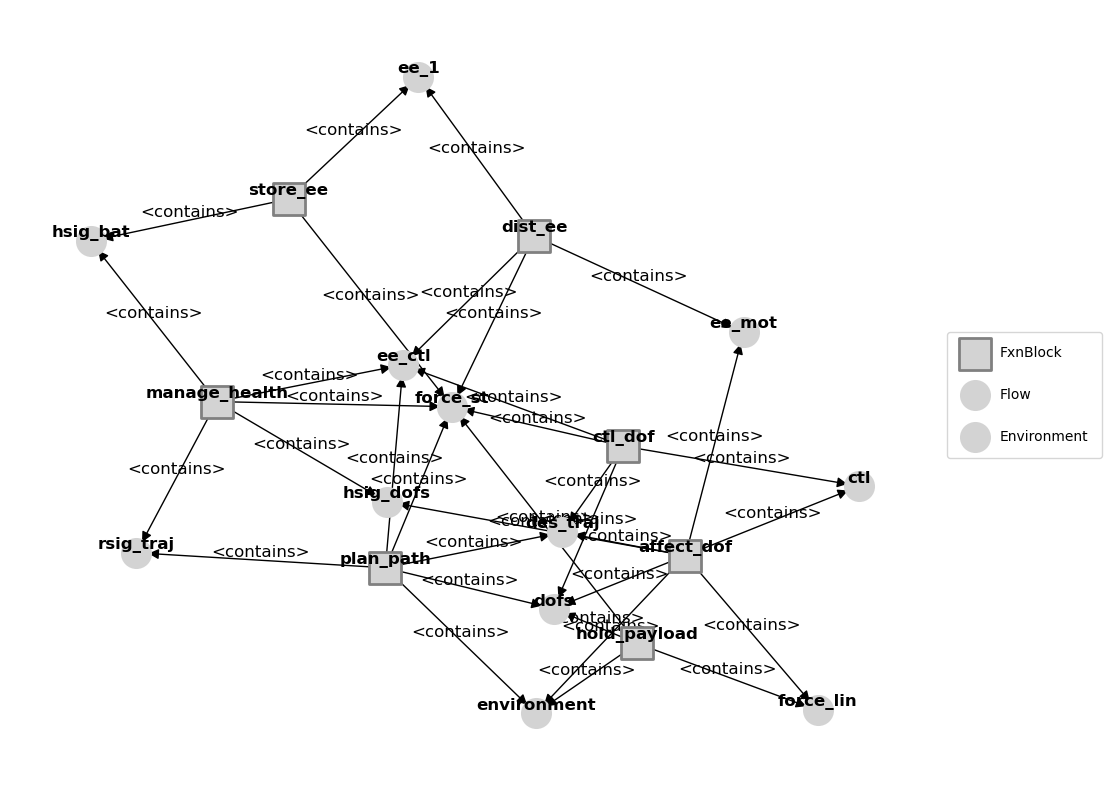

In [4]:
mg = an.graph.ModelGraph(mdl)
fig, ax = mg.draw()

We can also view the grid environment using methods in the `analyze.show` module:

In [5]:
fig, ax = an.show.grid(mdl.flows['environment'].g, "height",
                        collections={"all_occupied": {"color": "red"},
                                     "all_allowed": {"color": "blue"},
                                     "start": {"color": "blue"},
                                     "end": {"color": "blue"}})

AttributeError: module 'fmdtools.analyze.show' has no attribute 'grid'

Which shows the Start, End, and allowed/unsafe locations in the 1000x1000-m grid. In this display, line thickness corresponds to building height, and hatching corresponds to whether or not the space is occupied. We can also display this using `show.grid3d`:

In [10]:
fig, ax = an.show.grid3d(mdl.flows['environment'].g, "height",
                        collections={"all_occupied": {"color": "red"},
                                     "all_allowed": {"color": "blue"},
                                     "start": {"color": "blue"},
                                     "end": {"color": "blue"}})

## Nominal Simulation

Below we show how this drone performs in the nominal scenario.

In [11]:
results_nom, hist_nom =propagate.nominal(mdl)
fig, axs = an.plot.hist(hist_nom, "store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

As shown, the flight ends fairly quickly (in 10 minutes), with the drone successively proceeding through points in the flight plan.

We can also view this flightpath in 3-d space using `show.trajectories`:

In [16]:
fig, ax = an.show.trajectories(hist_nom, 'dofs.s.x', 'dofs.s.y', 'dofs.s.z')

Trajectory plots can be overlaid on top of environment plots. In this case, we defined the method `plot_env_with_traj` and `plot_env_with_traj3` for this case.

In [17]:
from drone_mdl_urban import plot_env_with_traj, plot_env_with_traj3d


In [20]:
plot_env_with_traj3d(hist_nom, mdl)

In [21]:
plot_env_with_traj(hist_nom, mdl)

As shown, this is a rather simple straight-line path. If we wanted a more complex scenario, we could make the path more complex by adding multiple destinations or planning the path based on allowed flight/landing locations.

As it is, we may also want to adjust the timestep/speed to get more resolution, since the drone only has a few discrete timesteps in the air.

The results for the simulation are:

In [22]:
results_nom

## Resilience model
A number of different faults have been implemented in the system.

For example, here we inject a mechanical fault in the left-rear rotor during flight:

In [23]:
mdl.fxns['affect_dof'].m.faultmodes

In [24]:
results_fault, hist_fault =propagate.one_fault(mdl, "affect_dof", "lr_mechbreak", time=2.0)

In [25]:
fig, axs = an.plot.hist(hist_fault, "store_ee.s.soc",
                            'ee_1.s.rate',
                            'dofs.s.z',
                            'plan_path.m.mode',
                            'plan_path.s.pt',
                            'des_traj.s.power')

In [26]:
plot_env_with_traj3d(hist_fault, mdl)

In [27]:
plot_env_with_traj(hist_fault, mdl)

In [28]:
results_fault

Here we inject a large list of faults in the system and evaluate their relative consequences in terms of metrics calculated in find_classification:

In [29]:
phases, modephases = hist_nom.get_modephases()
phases

In [30]:
from fmdtools.sim.approach import SampleApproach

from drone_mdl_urban import make_move_quad
move_quad=make_move_quad(hist_nom, phases['plan_path']['move'])
app = SampleApproach(mdl, phases=phases, modephases=modephases,
                     sampparams = {('PlanPath','move'): move_quad})
app

In [31]:
endresults, hists = propagate.approach(mdl, app, staged=False)

In [32]:
plot_env_with_traj3d(hists , mdl)

In [33]:
hists.get("nominal")

In [34]:
statsfmea = an.tabulate.fmea(endresults, app, group_by='fxnfault',
                            weight_metrics=['rate'],
                            avg_metrics=['unsafe_flight_time', 'cost', 'repcost',
                                         'landcost', 'body_strikes',
                                         'head_strikes', 'property_restrictions'],
                            sort_by='cost')
statsfmea